Instalamos los requerimientos requeridos según el tutorial proveído, utilizando comandos de línea en la terminal de la máquina virtual en ubuntu

In [1]:
# Instalar paquetes
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
!tar xf spark-3.2.2-bin-hadoop3.2.tgz
!pip -q install findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"
!pip -q install pyspark
!pip -q install geopandas attrs shapely rtree apache-sedona[spark]
#Descarga de Bases de Datos SCINCE 2020
!gdown 1erwHX0ZtIPiTYP5rYPZzaj2TgpWG9TdT
!unzip /content/SCINCE_Parquets.zip -d /content/SCINCE_Parquets/ &> /dev/null

     |████████████████████████████████| 281.4 MB 54 kB/s 
     |████████████████████████████████| 199 kB 65.0 MB/s 
     |████████████████████████████████| 1.0 MB 40.2 MB/s 
     |████████████████████████████████| 1.0 MB 82.8 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 16.7 MB 67.0 MB/s 
     |████████████████████████████████| 6.3 MB 82.7 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1erwHX0ZtIPiTYP5rYPZzaj2TgpWG9TdT
To: /content/SCINCE_Parquets.zip
100% 1.14G/1.14G [00:06<00:00, 167MB/s]


Instalamos ahora los paquetes de python que son necesarios para el procesamiento de datos y la comunicacioń con spark.

In [4]:
# Importar paquetes de python con los ajustes necesarios
import findspark
findspark.init()
import shapely
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
spark = SparkSession. \
builder. \
appName('GeoBigData'). \
config("spark.serializer", KryoSerializer.getName). \
config("spark.executor.memory", "5g"). \
config("spark.driver.memory", "10g"). \
config('spark.driver.maxResultSize', '5g'). \
config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,'
           'org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
getOrCreate()
SedonaRegistrator.registerAll(spark)

True

Ahora definimos los diccionarios de vars_cluster y aliases, que son los grupos de variables que utilizaremos para dividir a Durango en los segmentos que nos serán de interés, de acuerdo a las diferentes variables. Para fines de esta investigación definimos cuatro grupos de variables, separados en sets del 1 al 4 y con los que se harán las gráficas de clusters a continuación. Utilizaremos un iterador que se vaya por cada set y nos genere las gráficas para cada caso, sin necesidad de nosotros tener que escribir cada parte manual.

Se provee también una descripción de cada clave abajo de la creación de sets, para tener en cuenta que significa cada una. Para la representación de los datoas se eligieron unos aliases que es una versión corta de la descripción de cada código que sirve para darse una idea de qué representa cada uno sin tener que poner un nombre muy largo que obstruya la gráfica. Nótese que utilizamos _snake case_ para los aliases, ya que el parseador no permite el uso de espacios.

In [6]:
vars_cluster = {}
aliases = {}
#######
# SET 1
#######
vars_cluster[1] = ['ECO1_R', 'ECO7_R', 'EDU28_R', 'ECO40_R', 'ECO37_R', 'MOR1_R']
aliases[1] = ['act_econ','sin_escol','analfabeta','discapacidad','act_domesticas','hijos_fallecidos']
#######
# SET 2
#######
vars_cluster[2] = ['VIV22_R','VIV23_R','VIV24_R','ECO1_R']
aliases[2] = ['drenaje_y_sanitario','drenaje','no_drenaje','act_econ']
#######
# SET 3
#######
vars_cluster[3] = ['VIV22_R','VIV23_R','VIV24_R','ECO1_R','VIV25']
aliases[3] = ['drenaje_y_sanitario','drenaje','no_drenaje','act_econ','electricidad']
#######
# SET 4
#######
vars_cluster[4] = ['ECO1_R', 'ECO7_R', 'ECO40_R', 'ECO37_R']
aliases[4] = ['act_econ','sin_escol','discapacidad','act_domesticas']


#############################################################
# Descripción de códigos de variables
#############################################################

# ECO1_R - Porcentaje e población de 12 años y más económicamente activa
# ECO7_R - Porcentaje de población de 12 años y más ocupada sin escolaridad
# EDU28_R - Porcentaje de población de 15 años y más analfabeta
# ECO40_R - Porcentaje de población de 12 años y más no económicamente activa que tiene alguna discapacidad, limitación, problema o situación mental permamente que le impide trabajar 
# ECO37_R - Porcentaje de población de 12 años y más no económicamente activa que se dedica a los queaceres del hogar
# MOR1_R - Porcentaje e hijas e hijos fallecidos de la población femenina de 12 años y más

#  VIV25 - Viviendas particulares habitadas que disponen de energía eléctrica, agua entubada de la red pública y drenaje
#  VIV22_R - Porcentaje de ocupantes en viviendas particulares uqe disponen de drenaje y sanitario con admisión de agua
#  VIV23_R - Porcentaje de viviendas particulares habitadas que disponen de drenaje
#  VIV24_R - Porcentaje de viviendas particulares habitadas que no disponen de drenaje

En la siguiente función llamada `cluster_plot` cargamos los contenidos del parquet para Durango, que es el `10_DGO.parquet`, y seleccionamos únicamente las variables de interés, para cada caso de set de variables. Renombramos el alias de esta variable como `'manzanas'` para referenciarlo después. Filtramos los valores negativos (que implican una protección de identidad según la plática del INEGI) y los vectorizamos. Ya teniendo esto realizamos los clusters con las variables y los aliases escogidos para cada set y los agrupamos después por promedios (`mean`) y máximos (`max`). La predicción nos dirá en qué cluster está. Tomamos esta información y creamos una gráfica de radar para los máximos y los promedios de cada set de clusters. Cabe mencionar que no todas las gráficas nos fueron de utilidad, por lo que en el reporte hemos puesto solo las que consideramos relevantes para la investigación.

In [29]:
def clusterization(vars_cluster,aliases,num):
  BD_MANZANAS = spark.read.parquet(f"/content/SCINCE_Parquets/10_DGO.parquet")
  BD_MANZANAS_EEVVV = BD_MANZANAS.select('CVEGEO',*vars_cluster, 'geometry')
  BD_MANZANAS_EEVVV.cache()
  BD_MANZANAS_EEVVV.createOrReplaceTempView("manzanas") # Alias
  # Fitramiento de datos
  select = ',\n'.join([f'if( (isnull({var}) or {var} < 0), 0, {var}) as {var}' for var in vars_cluster])
  BD_MZA_EEVVV_CORREGIDO = spark.sql(f'select\nCVEGEO,\n{select},\ngeometry\nfrom manzanas')
  BD_MZA_EEVVV_CORREGIDO.cache()
  # vectorización
  vecAssembler = VectorAssembler(inputCols=vars_cluster, outputCol="features")
  BD_MZA_EEVVV_CORREGIDO_VEC = vecAssembler.transform(BD_MZA_EEVVV_CORREGIDO)
  BD_MZA_EEVVV_CORREGIDO_VEC.cache()
  # agrupamiento de clusters por k-medias
  kmeans = KMeans(k=5, seed=1, maxIter=250) 
  model = kmeans.fit(BD_MZA_EEVVV_CORREGIDO_VEC.select('features'))
  transformed = model.transform(BD_MZA_EEVVV_CORREGIDO_VEC)
  # selección del promedio para los clusters
  transformed.createOrReplaceTempView("result_kmeans")
  select_df = ',\n'.join([f'mean({var}) as {alias}' for var,alias in zip(vars_cluster,aliases)])
  clusters = spark.sql(f'select prediction,\n{select_df},\ncount(*) as conteo\nfrom result_kmeans group by prediction order by {aliases[0]}')
  return clusters.toPandas()

def cluster_plot(vars_cluster,aliases,num):
  df_clusters = clusterization(vars_cluster,aliases,num)
  # selección del máximo para los clusters
  select_df_max = ',\n'.join([f'max({var}) as {alias}' for var,alias in zip(vars_cluster,aliases)])
  clusters_max = spark.sql(f'select prediction,\n{select_df_max},\ncount(*) as conteo\nfrom result_kmeans group by prediction order by {aliases[0]}')
  df_clusters_max = clusters_max.toPandas()
  categories = df_clusters.columns[1:-1].values
  Clusters = [df_clusters.where(df_clusters.prediction==i).dropna().values[0][1:-1] for i in range(5)]
  Clusters = [[*cluster,cluster[0]] for cluster in Clusters]
  # linspace para graficar
  label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters[0]))
  # gráfica de promedios
  plt.figure(figsize=(10,10))
  plt.subplot(polar=True)
  for i in range(len(Clusters)):
    plt.plot(label_loc, Clusters[i], label=f'Cluster {i}')

  plt.title(f'Comparacion de clusters (promedios): Set {num}', size=20)
  lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
  plt.legend()
  plt.savefig(f'Clusters_{num}.png')
  # plt.close()
  print(f'mean cluster {num} done')

  categories = df_clusters_max.columns[1:-1].values
  Clusters = [df_clusters_max.where(df_clusters_max.prediction==i).dropna().values[0][1:-1] for i in range(5)]
  Clusters = [[*cluster,cluster[0]] for cluster in Clusters]

  label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters[0]))
  # gráfica de máximos
  plt.figure(figsize=(10, 10))
  plt.subplot(polar=True)
  for i in range(len(Clusters)):
    plt.plot(label_loc, Clusters[i], label=f'Cluster {i}')

  plt.title(f'Comparacion de clusters (máximos): Set {num}', size=20)
  lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
  plt.legend()
  plt.savefig(f'Clusters_{num}_max.png')
  # plt.close()
  print(f'max cluster {num} done')

Ya que tenemos la función, hacemos un ciclo por todos los sets de variables para clusterizar definidos arriba. Para esto utilizamos el método de `keys` del diccionario de `vars_cluster` definido anteriormente. En la función de arriba agregamos un `print` para medir progreso al ejecutar el código, ya que toma una buena cantidad de tiempo correrlo y siempre es bueno saber que sí está funcionando.

mean cluster 1 done
max cluster 1 done
mean cluster 2 done
max cluster 2 done
mean cluster 3 done
max cluster 3 done
mean cluster 4 done
max cluster 4 done


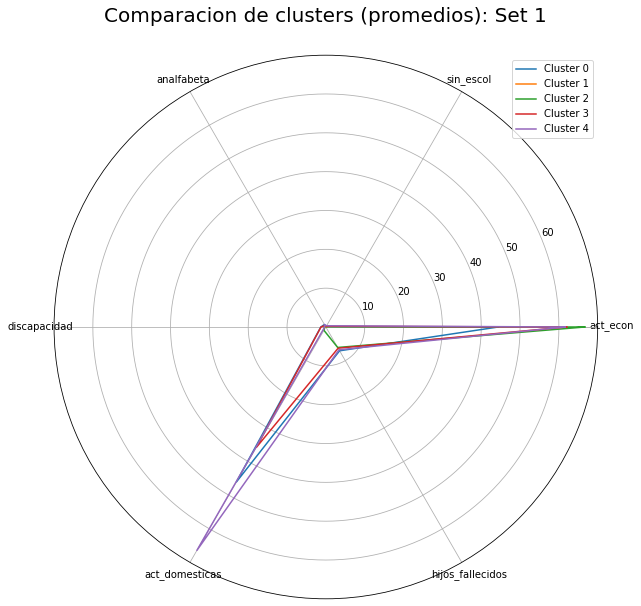

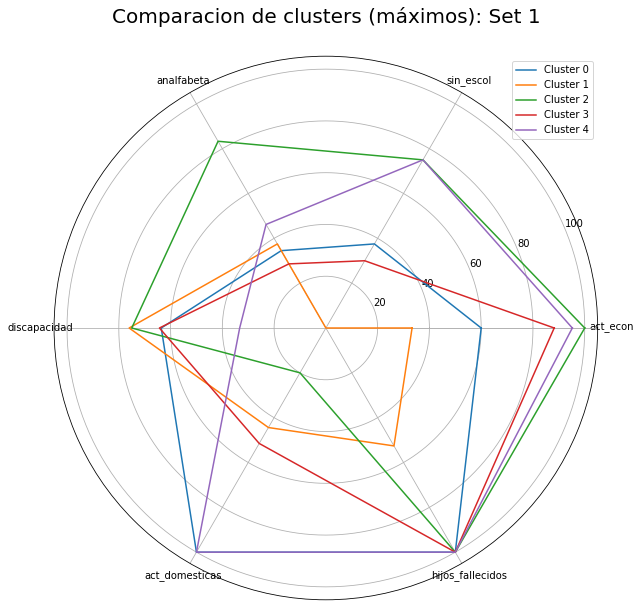

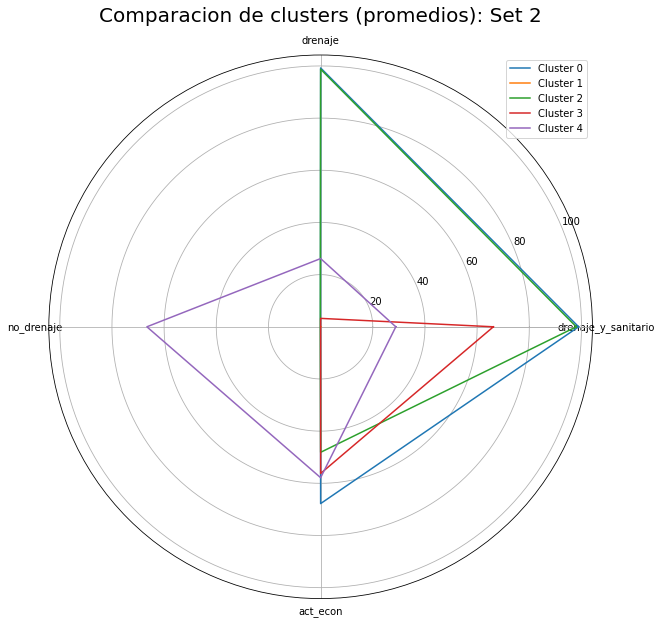

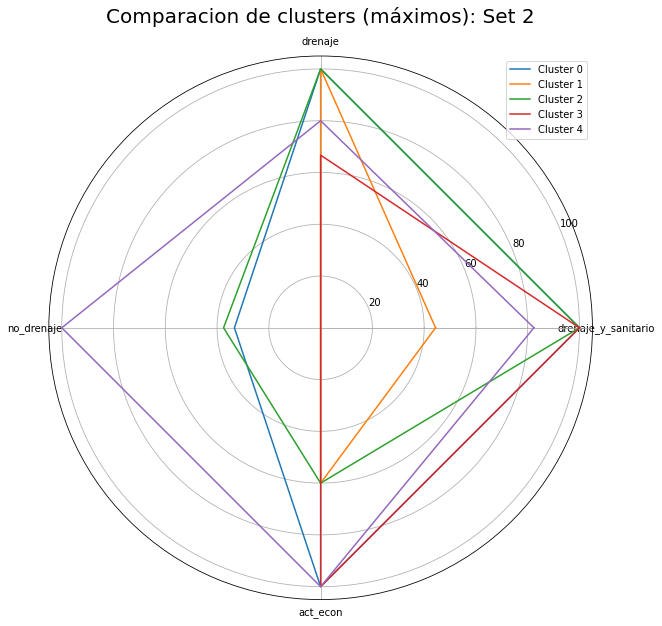

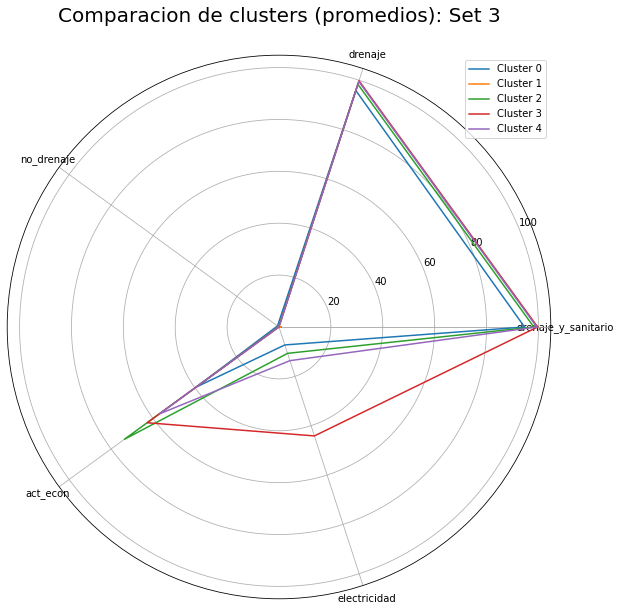

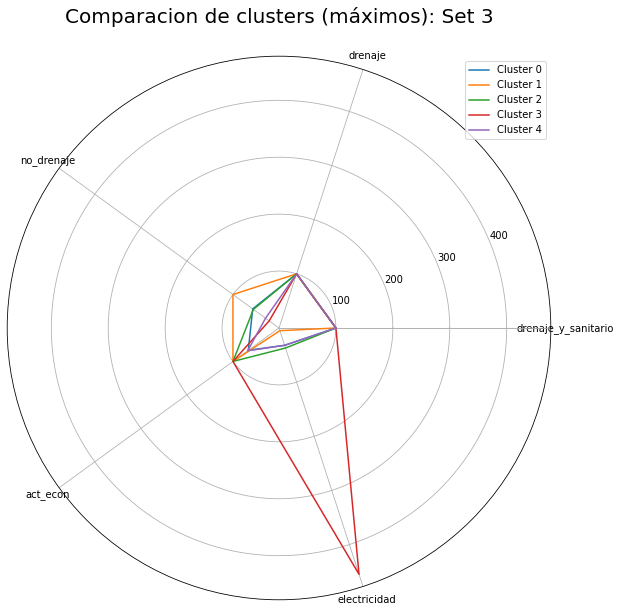

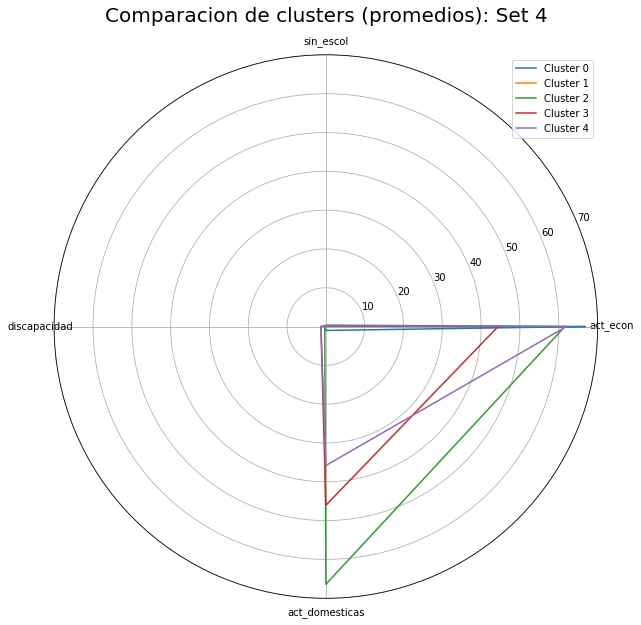

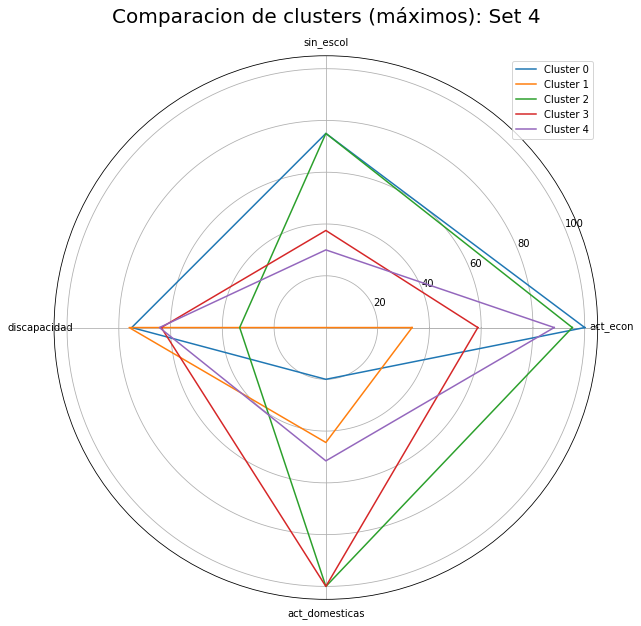

In [30]:
for num in vars_cluster.keys():
  cluster_plot(vars_cluster[num],aliases[num],num)

Posteriormente se prepara una visualización del mapa de Durango, centrándonos específicamente en las manzanas de Mezquital, como se puede ver a continuación:

Definimos un mapa de colores para la representación e importamos el módulo de folium para crear el mapa.

In [10]:
# Definir mapa de colores
def rank_colormap(gdf):
  if gdf['properties']['prediction'] is 4:
    return 'green'
  if gdf['properties']['prediction'] is 3 or 0:
    return 'yellow'
  if gdf['properties']['prediction'] is 1 or 2:
    return 'red'

import folium

Ahora creamos una función para hacer los mapas, de acuerdo a la clusterización de un número de cluster específico. Como ejemplo se harán para los sets 2 y 1

In [22]:
def create_color_map(cluster_num):
  df_cluster = clusterization(vars_cluster[cluster_num],aliases[cluster_num],cluster_num)
  select_df = ',\n'.join([f'{var} as {alias}' for var,alias in zip(vars_cluster[cluster_num],aliases[cluster_num])])
  df_manzanas = spark.sql(f'select {select_df},\ngeometry,\nprediction\nfrom result_kmeans').toPandas()
  geopandas_df_grid = gpd.GeoDataFrame(df_manzanas, geometry="geometry")
  proj = ['PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",','DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]]',
          ',PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],','PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]]',
          ',PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000]',
          ',PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1]',
          ',UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]']
  geopandas_df_grid = geopandas_df_grid.set_crs(''.join(proj))
  geopandas_df_grid = geopandas_df_grid.to_crs("EPSG:4326")

  m = folium.Map(location=[23.474203, -104.394908], zoom_start=14)

  folium.GeoJson(data = geopandas_df_grid, name="Estratos",style_function = lambda feature: {
    'fillColor': rank_colormap(feature),
    'color': rank_colormap(feature),
    'weight': '0.5',
    'fill': True,
    'fill_opacity': '1'
  }).add_to(m)
  return m

In [ ]:
create_color_map(2)

In [ ]:
create_color_map(1)

Se crearon los mapas para los sets de variables 2 y 1.